In [2]:
!module load cuda/11.7.1-fasrc01

In [3]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
import jax.nn as nn
import jax
import optax
import functools

import pydot
import numpy as np
from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
key = jax.random.PRNGKey(42)

## Sequences

In [ ]:
# sequences (fixed)
a = jnp.array([1,0,0,0]) #slightly changed
b = jnp.array([1,0,0,1])
c = jnp.array([0,1,1,0])

# ancestral sequences (???)
d = jnp.array([0,0,0,0]) # ? 
e = jnp.array([0,0,0,0]) # ?

In [ ]:
# similarity matrix (fixed)
sm = jnp.array([[0,1],
               [1,0]])

In [ ]:
seqs = jnp.array([a,b,c,d,e],dtype=np.float32)

## Tree Topology (also parameterized)

In [7]:
optimizer = optax.adam(0.1)
# params = {'d': jnp.array([0,0,0.0,0.0]), 'e': jnp.array([0,0.0,0,0.0])}

params = {'d': jax.random.normal(key, (4,)), 'e': jax.random.normal(key, (4,)), 
          't': jax.random.normal(key, (5,4))}


opt_state = optimizer.init(params)

In [8]:
t_q = jnp.round(nn.sigmoid(params['t']))

In [9]:
t_q

DeviceArray([[0., 1., 0., 0.],
             [0., 1., 1., 0.],
             [0., 1., 0., 1.],
             [1., 0., 1., 0.],
             [0., 1., 0., 1.]], dtype=float32)

In [10]:
#               a,b,c,d,e
t = jnp.array([[0,0,0,1,0], # a
               [0,0,0,1,0],  # b
               [0,0,0,0,1],  # c
               [0,0,0,0,1],  # d
               [0,0,0,0,1]]) # e

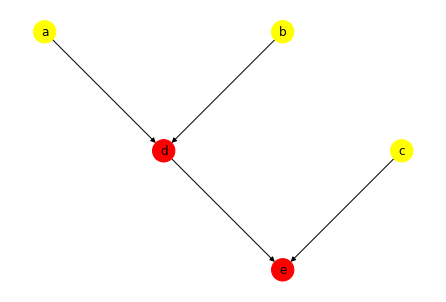

In [13]:
show_graph_with_labels(t,labels)

In [37]:
generate_t(5,3,1)

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]


DeviceArray([[0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 0.]], dtype=float32)

[[0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


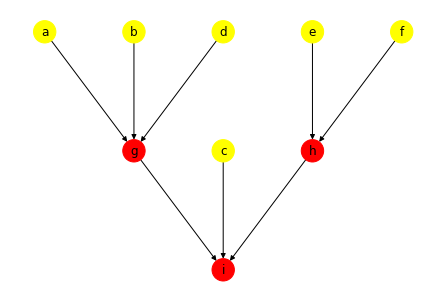

In [41]:
show_graph_with_labels(generate_t(9,6),6)

In [30]:
chr(97+0)

'a'

In [12]:


labels = {0:'a',1:'b',2:'c',3:'d',4:'e'}


In [19]:

t = t.at[-1,-1].set(1) ### need to add this (so that the last sequence is matched with itself) 

NameError: name 't' is not defined

### To generate a new topology run this line

In [8]:
t

DeviceArray([[0, 0, 0, 1, 0],
             [0, 0, 0, 1, 0],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1]], dtype=int32)

### Function to compute total distance

In [9]:
def compute_cost(sequences, tree, verbose = False):
    if(verbose==True):
        show_graph_with_labels(t,labels)
        
    selection = jnp.matmul(tree,sequences)
    
#     #method 1: (downside needs integers as we are indexing)
#     selection = selection.astype(int)
#     ans = sm[selection,sequences].sum()
    
    #method 2:
    ans = abs(selection - sequences).sum() ## works currently as sm is the basic config. need to think about extending
 
    return ans

In [10]:
seqs

DeviceArray([[1., 0., 0., 0.],
             [1., 0., 0., 1.],
             [0., 1., 1., 0.],
             [0., 0., 0., 0.],
             [0., 0., 0., 0.]], dtype=float32)

In [11]:
t

DeviceArray([[0, 0, 0, 1, 0],
             [0, 0, 0, 1, 0],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1]], dtype=int32)

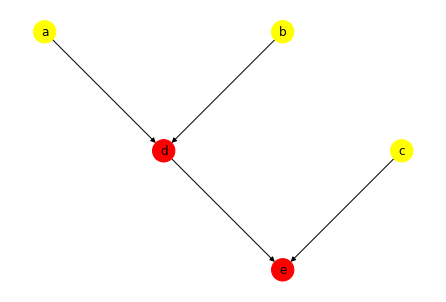

DeviceArray(5., dtype=float32)

In [12]:
compute_cost(seqs,t,1)

### Training

### initialize params

In [14]:
params

{'d': DeviceArray([ 0.18693547,  1.0653336 , -1.5593132 , -1.5352962 ], dtype=float32),
 'e': DeviceArray([ 0.18693547,  1.0653336 , -1.5593132 , -1.5352962 ], dtype=float32)}

In [15]:
def combine_to_seq(params, seqs, temperature = 1):
    seqs = seqs.at[-2].set(seqs[-2] + nn.sigmoid(temperature*params['d']))
    seqs = seqs.at[-1].set(seqs[-1] + nn.sigmoid(temperature*params['e']))
    
    return seqs

In [16]:
def compute_loss(params, seqs_, t):
    seqs_ = combine_to_seq(params, seqs)
    loss  = compute_cost(seqs_,t)
    
    return loss

In [17]:
compute_loss(params, seqs, t)

DeviceArray(5.5480757, dtype=float32)

In [18]:
for _ in range(500):
    grads = jax.grad(compute_loss)(params, seqs, t)
    
    if(_%100==0):
        print(compute_loss(params, seqs, t))
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)


5.5480757
4.044676
4.0176783
4.0099635
4.0065446


## Retrieving the new sequences array

In [19]:
discretized = jnp.round(combine_to_seq(params, seqs))

In [20]:
discretized

DeviceArray([[1., 0., 0., 0.],
             [1., 0., 0., 1.],
             [0., 1., 1., 0.],
             [1., 0., 0., 0.],
             [0., 1., 0., 0.]], dtype=float32)

### New cost

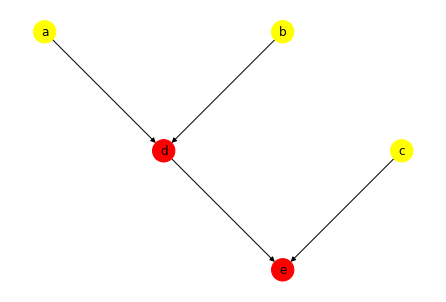

DeviceArray(4., dtype=float32)

In [21]:
compute_cost(discretized, t, 1)

### Old cost

In [22]:
compute_cost(seqs, t) ##when d & e were all zeros

DeviceArray(5., dtype=float32)

### test arbitrary sequence for d & e

In [23]:
test = jnp.array([[0, 0., 0., 0.],
                 [1., 0., 0., 1.],
                 [0., 1., 1., 0.],
                 [0., 0., 0., 0.],
                 [0., 0., 0., 0.]])

In [25]:
compute_cost(test, t)

DeviceArray(4., dtype=float32)